In [1]:
%matplotlib inline

from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from livelossplot import PlotLossesKerasTF

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
data = pd.read_csv('yelp.csv')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.text, 
                                                    data.stars, 
                                                    test_size = .2,
                                                    stratify = data.stars,
                                                    shuffle = True,
                                                    random_state = 123)

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [7]:
tokenizer = Tokenizer(num_words = 10000, oov_token='<unk>')
tokenizer.fit_on_texts(X_train)

In [8]:
X_tr = tokenizer.texts_to_sequences(X_train)
X_te = tokenizer.texts_to_sequences(X_test)

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
Xtr32 = pad_sequences(X_tr, maxlen = 32, padding='post', truncating = 'post')
Xte32 = pad_sequences(X_te, maxlen = 32, padding='post', truncating = 'post')

In [12]:
ytr = pd.get_dummies(y_train)
yte = pd.get_dummies(y_test)

In [13]:
config = {
    'embed_size': 64,
    'layer_size': 64,
    'output_size': ytr.shape[1],
    'dropout': .75,
    'epochs': 100,
    'batch_size': 32,
}

model = keras.Sequential([
  layers.Embedding(tokenizer.num_words, config['embed_size']),
  layers.GlobalAveragePooling1D(),
  layers.Dense(config['layer_size'], activation='relu'),
  layers.Dropout(config['dropout']),
  layers.Dense(config['output_size'], activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 1,288,581
Trainable params: 1,288,581
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(lr = 0.01,
                momentum = 0.9,
                nesterov = True)

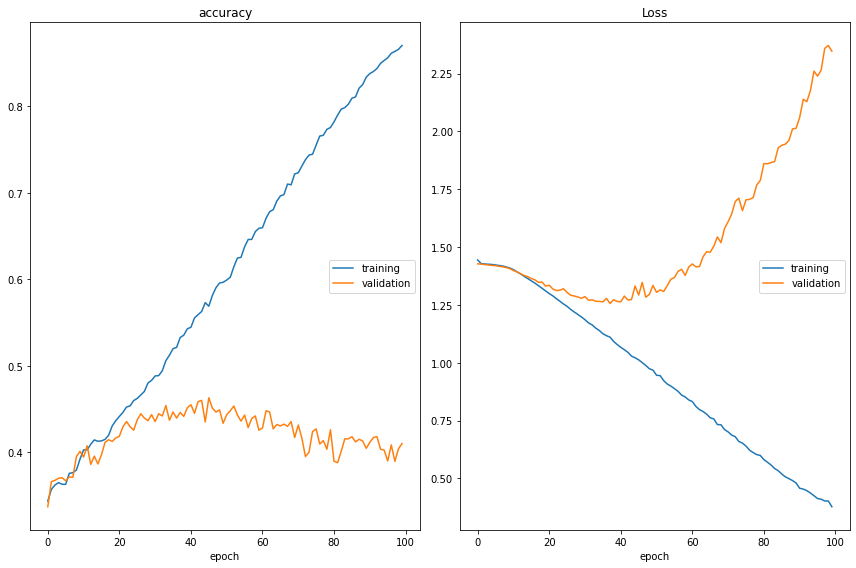

accuracy
	training         	 (min:    0.343, max:    0.870, cur:    0.870)
	validation       	 (min:    0.337, max:    0.463, cur:    0.410)
Loss
	training         	 (min:    0.378, max:    1.444, cur:    0.378)
	validation       	 (min:    1.256, max:    2.371, cur:    2.347)
8000/8000 [==============================] - 3s 370us/sample - loss: 0.3778 - accuracy: 0.8704 - val_loss: 2.3467 - val_accuracy: 0.4100


In [15]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

plot_losses = PlotLossesKerasTF()

history = model.fit(Xtr32, ytr.to_numpy(),
    batch_size = config['batch_size'],
    epochs=config['epochs'],
    validation_data=(Xte32, yte.to_numpy()),
    callbacks=[plot_losses])

In [16]:
def array_to_list(y_pred):
    return [np.argmax(y_pred[i,])+1 for i in range(y_pred.shape[0])]

In [19]:
def outputs(model):
    y_pred = array_to_list(model.predict(Xte32))
    print(classification_report(y_test, y_pred))
    print('\n')
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print('\n')
    print(f'Accuracy: {np.trace(cm)}/{np.sum(cm)} = {100*np.trace(cm)/np.sum(cm)}')